In [1]:
from plotting import *
from scipy.optimize import curve_fit

In [24]:
def Parse(dirIn, methods, convType, mom):
    num = len(methods)
    aveList = [] # python list, to be filled with np arrays
    errList = []
    dtList  = []
    labList = []
    for i in range(len(methods)):
        m = methods[i]
        if convType == 'w':
            nmom = '_mom'+mom+'_'
        else:
            nmom = ''
        prefix = dirIn + convType + m + nmom
        ave = prefix + '_ave.txt'
        err = prefix + '_sem.txt'
        dt  = prefix + '_dt.txt'
        if m[:2] == '_M':
            index = i - (methods[0]=='_EM')
            lab = 'MEM({})'.format(cors[index])
        else:
            lab = 'EM'

        aveList.append(np.loadtxt(ave))
        errList.append(np.loadtxt(err))
        dtList.append(np.loadtxt(dt))
        labList.append(lab)
    return dtList, aveList, errList, labList

In [28]:
def diffAnderr(ave, err):
    high = ave[:-1, :]
    low = ave[1:, :]
    diff = np.abs((high - low)/low) 
    err_low = err[1:, :] * (high / low**2) #the error on the denominator
    err_high = err[:-1, :] / low
    err = np.sqrt(err_low**2 + err_high**2)
    return diff, err

def power(x, c):
    return c * (x**1)

In [85]:
dirIn = 'output/base2/small/'
dirOut = 'figures/'
cors = ['0', '1', '2', '5']
mems = ['_MEM_cor_' + cor for cor in cors]
methods = ['_EM'] + mems
print(methods)
convType = 's'
mom = '1'

['_EM', '_MEM_cor_0', '_MEM_cor_1', '_MEM_cor_2', '_MEM_cor_5']


In [86]:
if mom == '1':
    name = 'Mean'
    symbol = '$<v_\parallel>$'
elif mom == '2':
    name = 'Variance'
    symbol = '$<v_\parallel^2>$'

if convType == 's':
    title = 'Strong Convergence'
elif convType == 'w':
    title = 'Weak Convergence'
else:
    print('type of convergence test not recognized')
    
fname = dirOut + convType + '_' + name + '.pdf'

In [82]:
dts, aves, errs, labs = Parse(dirIn, methods, convType, mom)
labs

['EM', 'MEM(0)', 'MEM(1)', 'MEM(2)', 'MEM(5)']

In [83]:
vcomp =0
truns = [None, None, None, None, None]
colors = pylab.cm.plasma(np.linspace(0.2,0.9, len(methods)))

Text(0.5, 0.93, 'Strong Convergence')

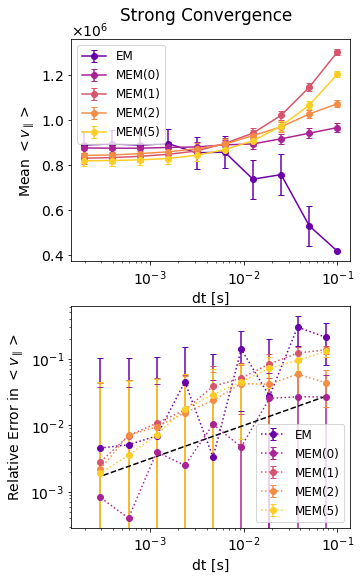

In [90]:
fig= plt.figure()
updateGlobal(14)
fig.set_size_inches(5, 9)
# plt.tight_layout()

ax1 = fig.add_subplot(211)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0), useMathText=True)
ax2 = fig.add_subplot(212, sharex = ax1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0), useMathText=True)


for dt, ave, err, lab, truncate, c in zip(dts, aves, errs, labs, truns, colors):

    ax1.errorbar(dt[:truncate], ave[:truncate, vcomp], err[:truncate, vcomp], 
                 color = c, marker = 'o', capsize = 3,label = lab)
    diff_ave, diff_err = diffAnderr(ave, err)
    t_mid = 0.5 * (dt[:-1] + dt[1:])
    
    # A power fit
    popt, pcov = curve_fit(power, t_mid[:truncate], diff_ave[:truncate, vcomp], 
                           sigma=diff_err[:truncate, vcomp], absolute_sigma=True,
                          )
    perr = np.sqrt(np.diag(pcov))
    # plot fit and data
#     ax2.plot(t_mid[:truncate], power(t_mid[:truncate], *popt), '-', color = c)
    ebar = ax2.errorbar(t_mid[:truncate], diff_ave[:truncate, vcomp], 
                 diff_err[:truncate, vcomp], 
                 color = c, fmt = 'o:', capsize = 3, label = lab)
# Reference line:
if convType == 'w':
    ax2.plot(t_mid[:truncate], 6*t_mid[:truncate], 'k--')
else:
    ax2.plot(t_mid[:truncate], 0.1 * t_mid[:truncate]**0.5, 'k--')
for ax in [ax1, ax2]:    
    ax.set_xscale('log')
    ax.set_xlabel('dt [s]')
    ax.legend()

ax1.set_ylabel(name + ' ' + symbol)

ax2.set_yscale('log')
ax2.set_ylabel('Relative Error in ' + symbol)
plt.suptitle(title, y = 0.93)
# fig.savefig(fname, bbox_inches = "tight")